In [177]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

1. Take-off from ship deck carrying the sonar
2. Travel 5 km (on a calm day) over the sea
3. Dive inside the water to a depth of about 500 meters
4. Search the ocean bed and leave the payload at an appropriate location.
5. Rise back to the surface
6. Return to the ship and land.

Relevant payload specifications:
* Weight = 5 kg
* Volume = 0.0025 m3
* Water proof (until 1000m depth)

1. Do the initial sizing of your vehicle rotor using Momentum Theory to decide on tentative
rotor dimensions and power requirement in hover. 

    Also check the rotor’s estimated power requirement under water.

In [178]:
from tools.BET import BETheory
from tools.BEM import BEMTheory

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [179]:
roAir = 1.225   # kg/m3 density of air
roWater = 1000  # kg/m3
g = 9.8         # m/s2

# The airfoil : NACA 2412. Simply because They used that in this paper: file:///home/kushal/Downloads/placement/NACA2412_airfoil_based_method_for_design_and_aerod.pdf
# Mean Chord length is defined couple of sells later
rBlade = 0.85 # m  Radius of the blade(rough estimate)
R_co = 0.15 # mine was 0.15
massOfStrutcutre= 10# kg this mass of everything other than payload mass.
angular_vel = 750*2*np.pi/60 
V = 0
# Given
massOfPayload = 5
volOfPayload = 0.0025
b = 3       # no of Blades . Tentatively decided on three
areaBlade = np.pi*(rBlade**2)

total_vol = 0.008 # The payload is gonna be taking a place inside this volume

In [180]:
def vel_power(V, medium='air'):
    if medium == 'air':
        T = (massOfStrutcutre + massOfPayload)*g; ro = roAir
    elif medium == 'water':
        ro = roWater
        T = (massOfStrutcutre + massOfPayload)*g - total_vol*ro*g
        
    ind_vel_MT = (-1*V/2) + np.sqrt(((V/2)**2) + (T/(2*ro*areaBlade)))
    power = T*(V + ind_vel_MT)
    return round(ind_vel_MT, 5) , round(power,4)

In [181]:
print('--'*5, 'MOMENTUM THEORY', '--'*5)
T_air = (massOfStrutcutre + massOfPayload)*g
print(f'T_air = {T_air}')
T_water = (massOfStrutcutre + massOfPayload)*g - total_vol*roWater*g
print(f'T_water = {T_water}')
print('HOVER')
indVel_Hover_MT, powerHover = vel_power(0)
print(f'(Power, Induced Vel) = ({powerHover: .4f}, {indVel_Hover_MT: .4f})')
indVel_Hover_MT,powerHover = vel_power(0,'water')
print(f'(Power, Induced Vel) = ({powerHover: .4f}, {indVel_Hover_MT: .4f})')

indVel_MT, powerClimb = vel_power(V)
print(f'Climb Vel = {V}')
print(f'(Power, Induced Vel) = ({powerClimb: .4f}, {indVel_MT: .4f})')
# I think the power to go downward in underwater is not a problem(gravity takes care of it).
indVel_MT_water,powerClimb_water = vel_power(V, 'water' )
print(f'(Power, Induced Vel) = ({powerClimb_water: .4f}, {indVel_MT_water: .4f})')

---------- MOMENTUM THEORY ----------
T_air = 147.0
T_water = 68.6
HOVER
(Power, Induced Vel) = ( 755.7864,  5.1414)
(Power, Induced Vel) = ( 8.4329,  0.1229)
Climb Vel = 0
(Power, Induced Vel) = ( 755.7864,  5.1414)
(Power, Induced Vel) = ( 8.4329,  0.1229)


OBSERVATION

The induced Velocity decreases in CLIMB


In [182]:
inducedVel_MT = np.sqrt(T_air/(2*roAir*areaBlade))
print(f'HOVER Induced Velocity = {inducedVel_MT: .4f}')

HOVER Induced Velocity =  5.1414


Wooh! That is significantly Low, we don't have to worry about water at all.

2. Make computational tools to implement BE Theory and BEM Theory with the Prandtl Tip 
Loss  model  (will  require  iterative  solving). 
    The  program  will  be  used  for  design  purpose; 
hence it should be flexible enough to allow setting linear twist, linear taper, and root cut-outs, 
and non-zero climb velocity. 

In [183]:
airfoil_file_path = './airfoil_data/xf-naca2412-il-500000.csv'
airfoil_data = pd.read_csv(airfoil_file_path, skiprows= 10)
alpha_cl_cd_data = airfoil_data[['Alpha', 'Cl', 'Cd']]
Cl = np.array(alpha_cl_cd_data['Cl'])
Cd = np.array(alpha_cl_cd_data['Cd'])
alpha = np.array(alpha_cl_cd_data['Alpha'])
Cl_Cd = Cl/Cd
alpha_optimum = alpha[np.argmax(Cl_Cd)]
print(f'AoA for max Cl/Cd = {alpha_optimum}')
lift_slope = 0.107015*180/np.pi
# lift_slope = 2*np.pi
print(f'Lift slope a = {lift_slope:.4f}')

AoA for max Cl/Cd = 5.0
Lift slope a = 6.1315


In [184]:
# This code ensures that No point in r an airfoil experiences Stall
# Esentially how its' done is we give a penalty for AoA > 13 and ask the optimizer to change A,B to minimize that penalty
from scipy.optimize import minimize
stall_angle = 12.5
def calc_AoA(r_ratio, A, B):
    tita = A + B*r_ratio*rBlade
    phi = np.arctan((V + inducedVel_MT)/(angular_vel*r_ratio*rBlade))
    # phi = np.arctan(rotor.lamda/r_ratio)
    return (tita - phi)*180/np.pi
def objecive(x):
    A,B =x
    aoa_values = [calc_AoA(r, A, B) for r in [0.18,0.3,0.4,0.45,0.5,0.6,0.68,0.75,0.8,0.9,0.95,0.98]]
    penalty = 0
    for aoa in aoa_values:
        if aoa > stall_angle or aoa < 0:
            penalty += abs(aoa - stall_angle) + abs(aoa)
    return penalty
initial_guess = [0.9, -1]
bounds = [(0.2, 2), (-2,2)]
result = minimize(objecive, initial_guess, bounds = bounds)
final_A, final_B = result.x

print(round(final_A,4), round(final_B,4))
print(result.fun)

0.4794 -0.467
0


In [185]:
def linear_twist(r_ratio):
    # e,f = final_A, final_B
    e,f = 0.3, -0.4
    return  e + f*r_ratio*rBlade
def linear_taper(r_ratio):
    return 0.12 - 0.02*r_ratio*rBlade
print(f'At a position r/R = 0.2, 0.75 the twist angle is {linear_twist(0.2):.4f}, {linear_twist(0.75):.4f}')
radii = np.linspace(R_co, rBlade, 100)
c_r = [linear_taper(r/rBlade) for r in radii ]
c_mean = np.mean(c_r)
print(f'Mean Chord Length : {c_mean}')

At a position r/R = 0.2, 0.75 the twist angle is 0.2320, 0.0450
Mean Chord Length : 0.11


In [186]:
rotorBlade = BETheory(
    angular_vel = angular_vel, no_of_blades= b, chord_mean= c_mean, 
    radius= rBlade, lift_slope=lift_slope, linear_twist=linear_twist, 
    climb_vel=V ,induced_vel= inducedVel_MT, root_cutouts=R_co) # I am using vel_power function defined for MT here

In [187]:
def drag(AoA):
    return 0.015
rotor = BEMTheory(
    angular_vel = angular_vel, no_of_blades= b, 
    radius= rBlade, lift_slope=lift_slope, drag = drag, linear_twist=linear_twist, 
    climb_vel=V , root_cutouts=R_co, linear_taper=linear_taper)
omega_water = 20*2*np.pi/60
rotor_water = BEMTheory(
    angular_vel = omega_water, no_of_blades= b, 
    radius= rBlade, lift_slope=lift_slope, drag = drag, linear_twist=linear_twist, 
    climb_vel=V , root_cutouts=R_co, linear_taper=linear_taper, medium='water')

In [188]:
for r_ratio in [0.18,0.3,0.4,0.45,0.5,0.6,0.68,0.75,0.8,0.9,0.95,0.98]:
    print(round(rotor.AoA(r_ratio)*180/np.pi , 3))

10.085
8.77
7.368
6.617
5.844
4.26
2.975
1.855
1.074
nan
nan
nan


/home/kushal/code/aero/rotaryWing/tools/BEM.py:25: RuntimeWarning: invalid value encountered in sqrt
  lamda = np.sqrt( ((self.sigma*self.a/(16*self.F) - l_c/2)**2)+ (self.sigma*self.a*self.linear_twist(r_ratio)*r_ratio/8) ) - (self.sigma*self.a/(16*self.F) - l_c/2)


In [189]:
r = 0.9 # this is a ratio x/R
print('C_P')
print(f'BET:{rotorBlade.C_P():.4f}, BEMT: {rotor.C_P():.4f}')
print('C_T')
print(f'BET:{rotorBlade.C_T()}, BEMT: {rotor.C_T():.4f}')
print('--'*5)
print(f'BET:  Lamda: {rotorBlade.lamda :.4f}')
print(f'BEMT is a func(r) Lamda,F :{rotor.lamda_tipLoss(r)}')
print(f'Tip Velocity: {angular_vel*rBlade:.4f}')

C_P
BET:-0.0004, BEMT: nan
C_T


/home/kushal/code/aero/rotaryWing/tools/BEM.py:31: RuntimeWarning: overflow encountered in exp
  F = (2/np.pi)*np.arccos(np.exp(-1*f))
/home/kushal/code/aero/rotaryWing/tools/BEM.py:31: RuntimeWarning: invalid value encountered in arccos
  F = (2/np.pi)*np.arccos(np.exp(-1*f))


BET:-0.00891, BEMT: nan
----------
BET:  Lamda: 0.0770
BEMT is a func(r) Lamda,F :(nan, nan)
Tip Velocity: 66.7588


In [190]:
print('POWER')
print(f'MT:{powerClimb: .3f}, BET:{rotorBlade.P():.3f}, BEMT: {rotor.P():.3f}')
print('Thrust')
print(f'MT:{T_air: .3f}, BET:{rotorBlade.T():.3f}, BEMT: {rotor.T():.3f}')
print('Induced Vel')
print(f'MT: {vel_power(V)[0]:.3f}, BET:{vel_power(V)[0]:.3f}, BEMT = func({r:.3f}): {round(rotor.lamda_tipLoss(r)[0]*angular_vel*rBlade - V,5) :.3f}')

POWER
MT: 755.786, BET:-365.892, BEMT: nan
Thrust
MT: 147.000, BET:-108.472, BEMT: nan
Induced Vel
MT: 5.141, BET:5.141, BEMT = func(0.900): nan


In [191]:
# the thrust with blade element momentum theory is more than BE. somethings wrong.\
# u have to get lesser thrust with non uniform velocity
#Okay it needs more power clearly. So I suppose the thrust is more here but power required is more too.

Text(0.5, 1.0, 'Coeff of Thrust vs Solidity')

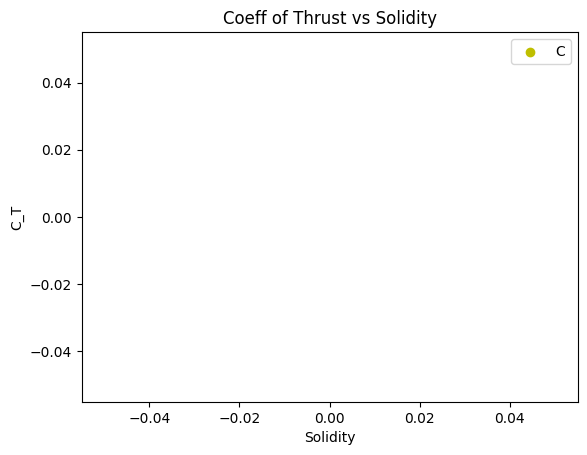

In [192]:
# Variation with solidity
def ct_cp(b, sigma): 
    sigma = sigma
    b = b
    def taper(r_ratio):
        return sigma*np.pi*rBlade/b
    def drag_aoa(AoA):
        return 0.015
    rotor_1 = BEMTheory(
                angular_vel = angular_vel, no_of_blades= b, 
                radius= rBlade, lift_slope=lift_slope, drag = drag_aoa, linear_twist=linear_twist, 
                climb_vel=V , root_cutouts=R_co, linear_taper=taper)
    return rotor_1.C_T(), rotor_1.C_P()
sigmas = np.linspace(0.01, 0.1, 30)
cts = [ct_cp(3,sigma)[0] for sigma in sigmas]
cps = [ct_cp(3,sigma)[1] for sigma in sigmas]
plt.scatter(sigmas, cts, color ='y')

plt.xlabel('Solidity')
plt.ylabel('C_T')
plt.legend('C_T')
plt.title('Coeff of Thrust vs Solidity')

Text(0.5, 1.0, 'Coeff of Power vs Solidity')

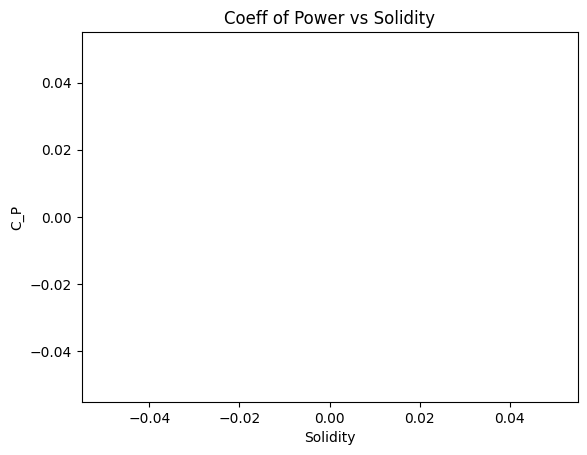

In [193]:
plt.scatter(sigmas, cps, color ='b')
plt.xlabel('Solidity')
plt.ylabel('C_P')
# plt.legend( 'C_P')
plt.title('Coeff of Power vs Solidity')

In [194]:
# Taper ration is c_tip/c_root

Text(0.5, 1.0, 'Coeff of Thrust vs Taper ratio( tip/root )')

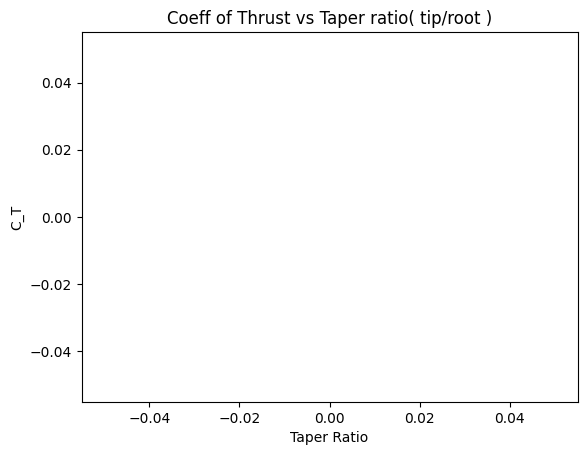

In [195]:
def ct_cp_c(taper_ratio):
    def taper(r_ratio):
        A = 0.15
        B = (A - A*taper_ratio) / (R_co - rBlade*taper_ratio) 
        return A - B*r_ratio*rBlade
    def drag_aoa(AoA):
        return 0.015
    rotor_1 = BEMTheory(
                angular_vel = angular_vel, no_of_blades= b, 
                radius= rBlade, lift_slope=lift_slope, drag = drag_aoa, linear_twist=linear_twist, 
                climb_vel=V , root_cutouts=R_co, linear_taper=taper)
    return rotor_1.C_T(), rotor_1.C_P()
ratios = np.linspace(0.1, 1, 30)
cts = [ct_cp_c(c)[0] for c in ratios]
plt.scatter(ratios, cts, color ='y')
plt.xlabel('Taper Ratio')
plt.ylabel('C_T')
plt.title('Coeff of Thrust vs Taper ratio( tip/root )')
    

Text(0.5, 1.0, 'Coeff of Thrust vs Taper ratio( tip/root )')

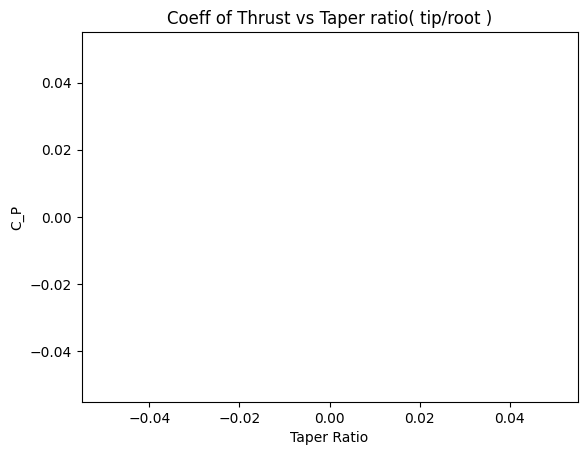

In [196]:
cps = [ct_cp_c(c)[1] for c in ratios]
plt.scatter(ratios, cps, color ='b')
plt.xlabel('Taper Ratio')
plt.ylabel('C_P')
plt.title('Coeff of Thrust vs Taper ratio( tip/root )')

In [197]:
print(final_A, final_B)

0.4793872555292476 -0.46697626119692937


In [198]:
def linear_twist(r_ratio):
    e,f = final_A, final_B
    return  e + f*r_ratio*rBlade
def linear_taper(r_ratio):
    return 0.1 - 0.02*r_ratio*rBlade

Text(0.5, 1.0, 'Coeff of Thrust vs Twist(tita: root-tip) ')

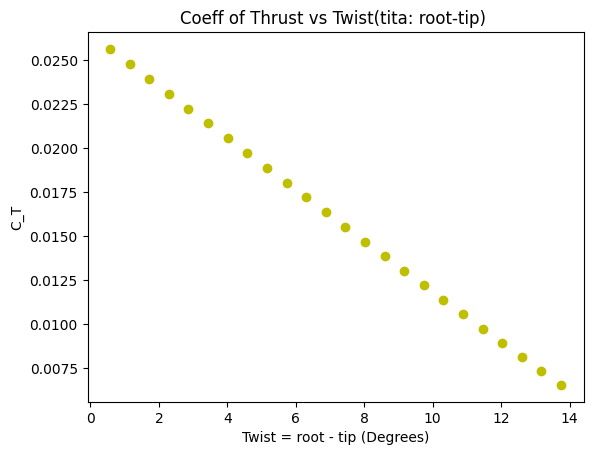

In [204]:
def ct_cp_tita(twist_diff):
    def twist(r_ratio):
        A = 0.3
        B = twist_diff/(rBlade-R_co)
        return A - B*r_ratio*rBlade
    def drag_aoa(AoA):
        return 0.015
    rotor_1 = BEMTheory(
                angular_vel = angular_vel, no_of_blades= b, 
                radius= rBlade, lift_slope=lift_slope, drag = drag_aoa, linear_twist=twist, 
                climb_vel=V , root_cutouts=R_co, linear_taper=linear_taper)
    return rotor_1.C_T(), rotor_1.C_P()
diffs= np.linspace(0.01, 0.4, 40)
cts = [ct_cp_tita(tita)[0] for tita in diffs]
tita_diffs = diffs*180/np.pi
plt.scatter(tita_diffs, cts, color ='y')
plt.xlabel('Twist = root - tip (Degrees)')
plt.ylabel('C_T')
plt.title('Coeff of Thrust vs Twist(tita: root-tip) ')

Text(0.5, 1.0, 'Coeff of Power vs Twist(tita: root-tip) ')

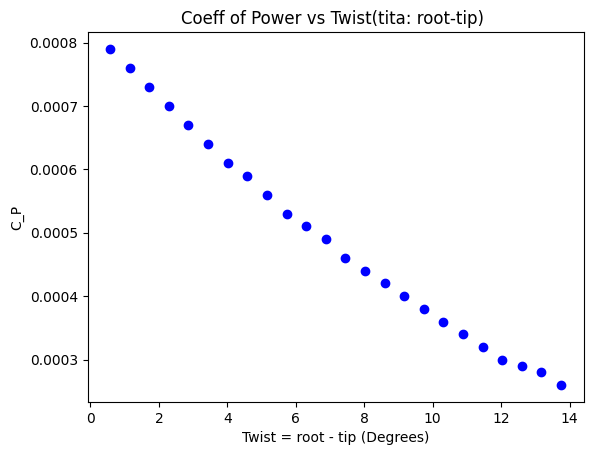

In [205]:
cps = [ct_cp_tita(tita)[1] for tita in diffs]
plt.scatter(tita_diffs, cps, color ='b')
plt.xlabel('Twist = root - tip (Degrees)')
plt.ylabel('C_P')
plt.title('Coeff of Power vs Twist(tita: root-tip) ')